# **1. Business Understanding (Memahami Bisnis)**

**1.1 Latar Belakang Masalah**

Sinyal sEMG (surface Electromyography) digunakan untuk membaca aktivitas otot tangan. Teknologi ini sangat penting di bidang:

- Prosthetic hand

- Robotik

- Rehabilitasi medis

- Human–Computer Interaction (HCI)

Namun, sinyal sEMG berbentuk time series kompleks, sehingga perlu klasifikasi otomatis berbasis machine learning.

**1.2 Tujuan Proyek**

Membangun model klasifikasi time series yang mampu mengenali jenis gerakan tangan berdasarkan sinyal sEMG dari dataset SemgHandMovementCh2 dan dengan akurasi tinggi yang mampu mengidentifikasi secara otomatis salah satu dari enam gerakan dasar tangan (Cylindrical, Hook, Tip, Palmar, Spherical, Lateral) berdasarkan sinyal sEMG (electromyography) dari Channel 2.

**1.3 Tujuan Analisis**

- Mengetahui pola sinyal sEMG untuk tiap gerakan tangan

- Melakukan preprocessing pada data time series

- Membangun model klasifikasi terbaik

- Mengevaluasi performa model

- Mendeploy model ke aplikasi web menggunakan Streamlit

**1.4 Kriteria Keberhasilan**
Mencapai akurasi klasifikasi yang kompetitif (di atas 90%) pada data uji (test set).

# **2. Instalasi Pustaka**

In [ ]:
# Instalasi Pustaka
# Instalasi pustaka yang dibutuhkan

!pip install numpy pandas scikit-learn tensorflow matplotlib
!pip install streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.3 MB/s eta 0:00:00


# **3. Mengunduh dan Memuat Data**



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Definisikan Fungsi untuk Memuat Data ---
def load_ucr_data(filepath):
    data = pd.read_csv(filepath, header=None, sep=r'\s+')

    # Pisahkan fitur (X) dan label (y)
    X = data.iloc[:, 1:].values
    y = data.iloc[:, 0].values

    # Label kelas untuk SemgHandMovementCh2 (1.0 hingga 6.0)
    # Kita akan ubah menjadi 0 hingga 5 agar sesuai dengan indexing Python
    y = y.astype(int) - 1

    return X, y

# --- PATH FILE DATASET ---
TRAIN_PATH = 'SemgHandMovementCh2_TRAIN.txt'
TEST_PATH = 'SemgHandMovementCh2_TEST.txt'

# Memuat data
try:
    X_train_raw, y_train_raw = load_ucr_data(TRAIN_PATH)
    X_test_raw, y_test_raw = load_ucr_data(TEST_PATH)

    print("Data berhasil dimuat.")
except FileNotFoundError:
    print("ERROR: Pastikan file data 'SemgHandMovementCh2_TRAIN' dan 'SemgHandMovementCh2_TEST' telah diunggah ke Colab.")
    exit()

Data berhasil dimuat.


# **4. Pemahaman dan Persiapan Data (Preprocessing)**
Kita akan melakukan pemeriksaan dimensi dan normalisasi data.

In [ ]:
## --- 1. Pemahaman Data (Pemeriksaan Dimensi) ---
print("\n## 1. PEMAHAMAN DATA (DIMENSI)")
print(f"Shape data latih (sampel, timesteps): {X_train_raw.shape}") # Harus (450, 1500)
print(f"Shape label latih: {y_train_raw.shape}")

# Periksa distribusi kelas
unique, counts = np.unique(y_train_raw, return_counts=True)
print(f"Distribusi kelas (0-5): {dict(zip(unique, counts))}")


## --- 2. PERSIAPAN DATA (PREPROCESSING) ---

# 2.1 Normalisasi/Standardisasi Data
scaler = StandardScaler()
# Standarisasi X_train
X_train_scaled = scaler.fit_transform(X_train_raw.T).T
# Standarisasi X_test menggunakan parameter dari X_train
X_test_scaled = scaler.transform(X_test_raw.T).T

# 2.2 Reshaping untuk Keras/TensorFlow (1D-CNN)
# Format harus: (sampel, timesteps, fitur/dimensi)
TIME_STEPS = X_train_scaled.shape[1]
DIMENSIONS = 1 # Karena ini sinyal sEMG 1 channel

X_train = X_train_scaled.reshape(-1, TIME_STEPS, DIMENSIONS)
X_test = X_test_scaled.reshape(-1, TIME_STEPS, DIMENSIONS)

# 2.3 One-Hot Encoding Label
NUM_CLASSES = 6
y_train = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_test_labels = y_test_raw # Simpan label asli untuk evaluasi

print("Data telah dinormalisasi dan di-reshape.")
print(f"Shape X_train akhir: {X_train.shape}")
print(f"Shape y_train akhir (One-Hot): {y_train.shape}")


## 1. PEMAHAMAN DATA (DIMENSI)
Shape data latih (sampel, timesteps): (450, 1500)
Shape label latih: (450,)
Distribusi kelas (0-5): {np.int64(0): np.int64(75), np.int64(1): np.int64(75), np.int64(2): np.int64(75), np.int64(3): np.int64(75), np.int64(4): np.int64(75), np.int64(5): np.int64(75)}
Data telah dinormalisasi dan di-reshape.
Shape X_train akhir: (450, 1500, 1)
Shape y_train akhir (One-Hot): (450, 6)


# **5. Pemodelan Data (Modeling) - 1D CNN**

Kita akan membangun dan melatih model 1D-CNN yang efektif untuk klasifikasi time series.

In [ ]:
## --- 5. PEMODELAN DATA (1D-CNN) ---

def build_1d_cnn_model(input_shape, num_classes):
    """Membangun arsitektur 1D-CNN sederhana."""
    model = Sequential()

    # Layer Konvolusi 1
    model.add(Conv1D(filters=64, kernel_size=10, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.3))

    # Layer Konvolusi 2
    model.add(Conv1D(filters=128, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.3))

    # Layer Konvolusi 3
    model.add(Conv1D(filters=256, kernel_size=10, activation='relu'))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Dropout(0.3))

    # Flatten dan Dense Layers
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax')) # Output layer untuk 6 kelas

    # Kompilasi model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Buat dan tampilkan ringkasan model
model = build_1d_cnn_model(input_shape=(TIME_STEPS, DIMENSIONS), num_classes=NUM_CLASSES)
print("\n## 3. RINGKASAN MODEL 1D-CNN")
model.summary()

# Latih Model
# Sesuaikan epochs dan batch_size jika diperlukan
print("\n## 3. PELATIHAN MODEL...")
history = model.fit(
    X_train,
    y_train,
    epochs=50, # Jumlah epochs idealnya lebih tinggi, coba 50-100
    batch_size=32,
    validation_split=0.1, # Ambil 10% data latih untuk validasi
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



## 3. RINGKASAN MODEL 1D-CNN


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1491, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 497, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 497, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 488, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 162, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 162, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 153, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 51, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 51, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13056)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     6,528,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,942,194 (26.48 MB)

 Trainable params: 6,942,194 (26.48 MB)

 Non-trainable params: 0 (0.00 B)


## 3. PELATIHAN MODEL...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 558ms/step - accuracy: 0.1469 - loss: 4.0361 - val_accuracy: 0.0222 - val_loss: 1.9856
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 479ms/step - accuracy: 0.3458 - loss: 1.6474 - val_accuracy: 0.2667 - val_loss: 1.8376
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 589ms/step - accuracy: 0.4764 - loss: 1.3713 - val_accuracy: 0.2667 - val_loss: 1.5979
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 481ms/step - accuracy: 0.5260 - loss: 1.2155 - val_accuracy: 0.2667 - val_loss: 1.4927
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 594ms/step - accuracy: 0.5360 - loss: 1.2406 - val_accuracy: 0.2667 - val_loss: 1.8601
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 830ms/step - accuracy: 0.5854 - loss: 1.0362 - val_accuracy: 0.1333 - val_loss: 2.0265
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 692ms/step - accuracy: 0.5799 - loss: 1.0698 - val_accuracy: 0.2889 - val_loss: 1.6841
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 939ms/step - accuracy: 0.6196 - lo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Dropout, BatchNormalization, Dense

## --- 5B. PEMODELAN DATA (FCN) ---

def build_fcn_model(input_shape, num_classes):
    """Membangun arsitektur Fully Convolutional Network (FCN) sederhana."""
    model = Sequential()

    # Blok Konvolusi 1
    model.add(Conv1D(filters=128, kernel_size=8, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    # Blok Konvolusi 2
    model.add(Conv1D(filters=256, kernel_size=5, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    # Blok Konvolusi 3
    model.add(Conv1D(filters=128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))

    # Global Average Pooling (Mengganti Flatten & Dense yang besar)
    model.add(GlobalAveragePooling1D())

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Kompilasi model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Buat, latih, dan evaluasi Model FCN
fcn_model = build_fcn_model(input_shape=(TIME_STEPS, DIMENSIONS), num_classes=NUM_CLASSES)
print("\n## 3B. RINGKASAN MODEL FCN")
fcn_model.summary()

print("\n## 3B. PELATIHAN MODEL FCN...")
fcn_history = fcn_model.fit(
    X_train,
    y_train,
    epochs=50, # Gunakan jumlah epochs yang sama untuk perbandingan awal
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluasi FCN
fcn_loss, fcn_accuracy = fcn_model.evaluate(X_test, to_categorical(y_test_labels, num_classes=NUM_CLASSES), verbose=0)
print("\n## 4B. AKURASI FCN PADA DATA UJI")
print(f"Akurasi Model FCN pada Data Uji: {fcn_accuracy*100:.2f}%")
print(f"Loss Model FCN pada Data Uji: {fcn_loss:.4f}")

# Simpan Model FCN
fcn_model.save('semg_fcn_model.h5')
print("Model FCN telah disimpan sebagai 'semg_fcn_model.h5'.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



## 3B. RINGKASAN MODEL FCN


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1500, 128)      │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1500, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1500, 256)      │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1500, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1500, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1500, 128)      │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1500, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1500, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,502 (1.02 MB)

 Trainable params: 265,478 (1.01 MB)

 Non-trainable params: 1,024 (4.00 KB)


## 3B. PELATIHAN MODEL FCN...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.2521 - loss: 1.7360 - val_accuracy: 0.0000e+00 - val_loss: 1.9880
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.3806 - loss: 1.5546 - val_accuracy: 0.2667 - val_loss: 1.8585
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3751 - loss: 1.4907 - val_accuracy: 0.4667 - val_loss: 1.5134
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4222 - loss: 1.4312 - val_accuracy: 0.2667 - val_loss: 1.3384
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4207 - loss: 1.4749 - val_accuracy: 0.9333 - val_loss: 0.9313
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4552 - loss: 1.4127 - val_accuracy: 0.3556 - val_loss: 1.0501
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.4175 - loss: 1.4454 - val_accuracy: 0.2889 - val_loss: 0.9858
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4539 - loss: 1.3927


## 4B. AKURASI FCN PADA DATA UJI
Akurasi Model FCN pada Data Uji: 23.78%
Loss Model FCN pada Data Uji: 12.0270
Model FCN telah disimpan sebagai 'semg_fcn_model.h5'.


# **6. Evaluasi (Evaluation)**

Mengukur performa model pada data uji dan visualisasi hasilnya.


## 4. AKURASI PADA DATA UJI
Akurasi Model pada Data Uji: 42.89%
Loss Model pada Data Uji: 5.1476
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step

## 4. LAPORAN KLASIFIKASI (Precision, Recall, F1-Score)
              precision    recall  f1-score   support

 Cylindrical       0.53      0.52      0.53        75
        Hook       0.38      0.67      0.49        75
         Tip       0.73      0.32      0.44        75
      Palmar       0.34      0.47      0.39        75
   Spherical       0.40      0.32      0.36        75
     Lateral       0.43      0.28      0.34        75

    accuracy                           0.43       450
   macro avg       0.47      0.43      0.42       450
weighted avg       0.47      0.43      0.42       450



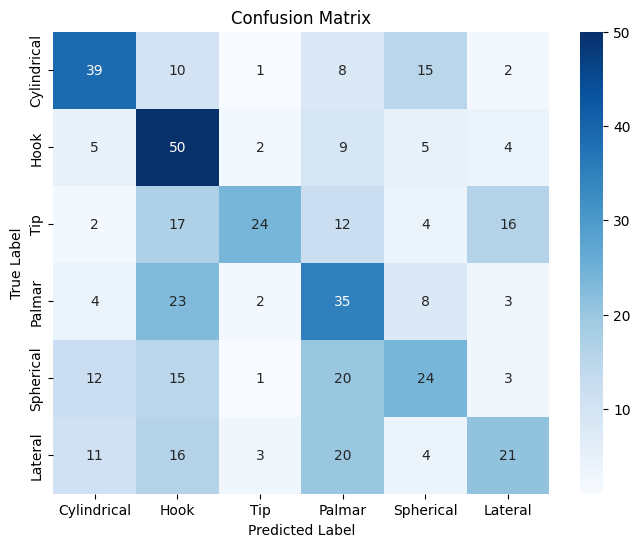

In [ ]:
## --- 6. EVALUASI MODEL ---

# 6.1 Menghitung Akurasi pada Data Uji
print("\n## 4. AKURASI PADA DATA UJI")
loss, accuracy = model.evaluate(X_test, to_categorical(y_test_labels, num_classes=NUM_CLASSES), verbose=0)
print(f"Akurasi Model pada Data Uji: {accuracy*100:.2f}%")
print(f"Loss Model pada Data Uji: {loss:.4f}")

# 6.2 Laporan Klasifikasi Rinci
# Prediksi
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# Laporan Klasifikasi
print("\n## 4. LAPORAN KLASIFIKASI (Precision, Recall, F1-Score)")
# Label 0=Cylindrical, 1=Hook, 2=Tip, 3=Palmar, 4=Spherical, 5=Lateral
target_names = ['Cylindrical', 'Hook', 'Tip', 'Palmar', 'Spherical', 'Lateral']
print(classification_report(y_test_labels, y_pred, target_names=target_names))

# 6.3 Visualisasi Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# **7. Deployment (Streamlit)**

Setelah model dievaluasi, Anda perlu menyimpan model dan membuat script Streamlit terpisah.

In [3]:
## --- 7. DEPLOYMENT (Penyimpanan Model) ---

# Simpan model untuk digunakan di Streamlit
model.save('semg_hand_movement_cnn_model.h5')
print("✅ Model telah disimpan sebagai 'semg_hand_movement_cnn_model.h5'.")

# Simpan Scaler (penting agar preprocessing di Streamlit sama dengan saat training)
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler telah disimpan sebagai 'scaler.pkl'.")

# Simpan target_names untuk pemetaan label
import json
with open('target_names.json', 'w') as f:
    json.dump(target_names, f)
print("✅ Target names telah disimpan sebagai 'target_names.json'.")

NameError: name 'model' is not defined